In [1]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import shap

### loading data

In [2]:
data = pd.read_csv('kkbox/train.csv')
members = pd.read_csv('kkbox/members.csv')
songs = pd.read_csv('kkbox/songs.csv')
songs_extra = pd.read_csv('kkbox/song_extra_info.csv')

#### data

Добавим фичу - доля прослушиваний на репите от всех первых прослушиваний песни. 

In [3]:
data1 = data[['song_id', 'target']]
song_played = data1.groupby('song_id', as_index=False).count().rename(columns={'target': 'num_played'})
song_repeated = data1.groupby('song_id', as_index=False).sum().rename(columns={'target': 'num_repeated'})
song_rate = pd.merge(song_played, song_repeated, on='song_id')
song_rate['song_repeated_rate'] = round(song_rate['num_repeated'] / song_rate['num_played'], 1)
song_rate.loc[song_rate['num_played'] == 1, 'song_repeated_rate'] = np.nan
song_rate.drop(columns=['num_played', 'num_repeated'], inplace=True)
data = data.merge(song_rate, on='song_id', how='left')

del data1, song_played, song_repeated, song_rate

#### members

* Скажем, что, если возраст младше 14 и старше 60, то у нас нет по нему данных. 
* Вместо времени и даты регистрации добавим длительность подписки в месяцах и годах.
* Уберем пол

In [4]:
members.loc[(members['bd'] < 14) | (members['bd'] > 60), 'bd'] = np.nan

members['expiration_date'] = pd.to_datetime(members['expiration_date'], format='%Y%m%d')
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
members['membership_duration_d'] = (members['expiration_date'] - members['registration_init_time']).dt.days 
members['membership_duration_m'] = members['membership_duration_d'] // 30
members['membership_duration_y'] = members['membership_duration_d'] // 365
members = members.loc[~members['membership_duration_m'] < 0]
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[:4]))
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[:4]))

members.drop(columns=['gender', 'registration_init_time', 'expiration_date', 'membership_duration_d'], inplace=True) 

#### songs

* Добавим фичу - исполнитель песни был одним из людей, кто написал музыку и/или текст.

In [5]:
def artist_is_creator(artist, composer, lyricist):
    artist = re.findall(r"[\w']+", str(artist))
    composer = re.findall(r"[\w']+", str(composer))
    lyricist = re.findall(r"[\w']+", str(lyricist))
    artist_is_composer = set(artist).intersection(set(composer))
    artist_is_lyricist = set(artist).intersection(set(lyricist))
    return len(artist_is_composer) != 0 or len(artist_is_lyricist) != 0 

def count_num(x):
    return str(x).count('|') + 1

def return_first(x):
    return str(x).split('|')[0]

songs.loc[songs['language'] == -1] = np.nan

songs['artist_num'] = songs['artist_name'].apply(count_num)
songs['artist_is_creator'] = [int(artist_is_creator(a, c, l)) for a, c, l in zip(songs['artist_name'], songs['composer'], songs['lyricist'])]
songs['artist_name'] = songs['artist_name'].apply(return_first)

songs['num_genres'] = songs['genre_ids'].apply(count_num)
songs['genre_ids'] = songs['genre_ids'].apply(return_first)

songs.drop(columns=['composer', 'lyricist'], inplace=True)

#### songs extra info

* Добавим фичу - десятилетие, когда песня была выпущена.

In [6]:
def year_of_reference(isrc):
    if type(isrc) == str:
        year = int(isrc[5:7])
        if year <= 17:
            return year // 10 * 10
        return 0
    return np.nan

songs_extra['song_decade'] = songs_extra['isrc'].apply(lambda x: year_of_reference(x))

songs_extra.drop(columns=['name', 'isrc'], inplace=True)

#### merging

In [7]:
data = data.merge(members, on='msno', how='left')
data = data.merge(songs, on='song_id', how='left')
data = data.merge(songs_extra, on='song_id', how='left')

del members, songs, songs_extra

In [8]:
data1 = data[['artist_name', 'target']]
artist_played = data1.groupby('artist_name', as_index=False).count().rename(columns={'target': 'num_played'})
artist_repeated = data1.groupby('artist_name', as_index=False).sum().rename(columns={'target': 'num_repeated'})
artist_rate = pd.merge(artist_played, artist_repeated, on='artist_name', how='left')
artist_rate['artist_repeated_rate'] = round(artist_rate['num_repeated'] / artist_rate['num_played'], 1)
artist_rate.loc[artist_rate['num_played'] == 1, 'artist_repeated_rate'] = np.nan
artist_rate.drop(columns=['num_played', 'num_repeated'], inplace=True)

data = data.merge(artist_rate, on='artist_name', how='left')
del data1, artist_played, artist_rate

In [9]:
category_cols = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 
                 'genre_ids', 'artist_name', 'language', 'artist_is_creator', 'song_decade']

for col in category_cols:
    data[col] = data[col].astype('category')

X = data.drop(columns=['target'])
y = data['target']
X.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'song_repeated_rate', 'city', 'bd', 'registered_via',
       'membership_duration_m', 'membership_duration_y', 'registration_year',
       'expiration_year', 'song_length', 'genre_ids', 'artist_name',
       'language', 'artist_num', 'artist_is_creator', 'num_genres',
       'song_decade', 'artist_repeated_rate'],
      dtype='object')

### GB

#### На каких-то не fine-tuned параметрах выделим самые важные фичи с помощью большой гаммы. 

In [13]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2)

In [26]:
params = {'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'min_gain_to_split': 5,
        'num_leaves': 128,
        'max_depth': 10,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'metric' : 'auc'}

dtrain = lgb.Dataset(X_train0, y_train0)
dtrain_watch = lgb.Dataset(X_train0, y_train0)
model = lgb.train(params, train_set=dtrain, num_boost_round=50, valid_sets=dtrain_watch, verbose_eval=5,
                 categorical_feature=category_cols)

categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_is_creator', 'artist_name', 'city', 'genre_ids', 'language', 'msno', 'song_decade', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']


[LightGBM] [Info] Number of positive: 2972286, number of negative: 2929648
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.383300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33801
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503612 -> initscore=0.014449
[LightGBM] [Info] Start training from score 0.014449
[5]	valid_0's auc: 0.728186
[10]	valid_0's auc: 0.734581
[15]	valid_0's auc: 0.739208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's auc: 0.743563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's auc: 0.74753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [31]:
y_test0_pred = model.predict(X_test)
score = roc_auc_score(y_test0, y_test0_pred)
print('Test AUC: {:.3f}' .format(score))

Test AUC: 0.756


[]

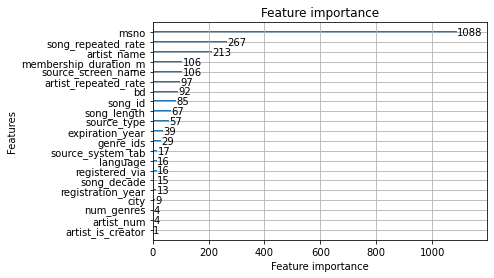

In [16]:
lgb.plot_importance(model).plot()

In [32]:
shap_values = shap.TreeExplainer(model).shap_values(X_train0)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


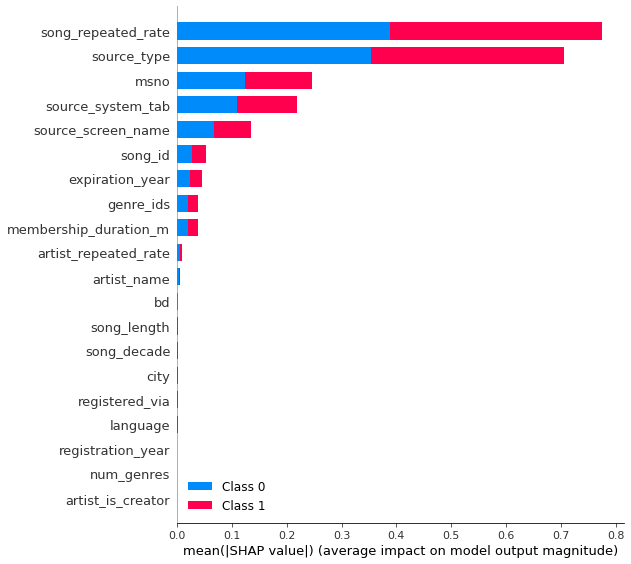

In [37]:
shap.summary_plot(shap_values, X_train0)

Shapley values и использование internal feature significance выделили примерно одинаковый по составу top-10, 
но внутри него фичи перемешаны. Кажется порядок фичей и сами фичи, выделенные с помощью shap values, более логичны: например, msno не
должен быть определяющим фактором и возраст пользователей скорее всего ни на что не влияет. Кроме того, можно заметить, что для обоих классов все фичи имеют приблизительно одинаковую важность. Возьмем 11 наиболее важных факторов.

In [10]:
X = data[['song_repeated_rate', 'source_type', 'msno', 'source_system_tab', 'source_screen_name', 'song_id', 
          'expiration_year', 'genre_ids', 'membership_duration_m', 'artist_repeated_rate', 'artist_name']]
y = data['target']

category_cols = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 
                 'genre_ids', 'artist_name']

In [13]:
params = {'objective': 'binary',
          'learning_rate': 0.1, 
          'min_gain_to_split': 0,
          'min_child_weight': 2, 
          'max_depth': 10,
          'subsample': 0.8,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'n_estimators': 150}

#### max_depth_range и min_child_weight

In [14]:
params1 = {'max_depth': range(6, 11, 2),
           'min_child_weight': range(2, 7, 2)}

train_test_split = ShuffleSplit(test_size=0.2, n_splits=1)
gsearch1 = GridSearchCV(estimator=lgb.LGBMClassifier(**params), 
                        param_grid=params1, 
                        scoring='roc_auc', 
                        cv=train_test_split,  
                        verbose=1)

gsearch1.fit(X, y)
gsearch1.cv_results_['params'], gsearch1.cv_results_['split0_test_score'], gsearch1.best_params_

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 30.0min finished


[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


([{'max_depth': 6, 'min_child_weight': 2},
  {'max_depth': 6, 'min_child_weight': 4},
  {'max_depth': 6, 'min_child_weight': 6},
  {'max_depth': 8, 'min_child_weight': 2},
  {'max_depth': 8, 'min_child_weight': 4},
  {'max_depth': 8, 'min_child_weight': 6},
  {'max_depth': 10, 'min_child_weight': 2},
  {'max_depth': 10, 'min_child_weight': 4},
  {'max_depth': 10, 'min_child_weight': 6}],
 array([0.75240682, 0.75246514, 0.75244557, 0.7585929 , 0.7586529 ,
        0.75840956, 0.76290332, 0.76293653, 0.76289856]),
 {'max_depth': 10, 'min_child_weight': 4})

In [15]:
params['max_depth'] = gsearch1.best_params_['max_depth']
params['min_child_weight'] = gsearch1.best_params_['min_child_weight']

#### gamma

In [18]:
params2 = {'min_gain_to_split': [i / 10.0 for i in range(0,5)]}

train_test_split = ShuffleSplit(test_size=0.2, n_splits=1)
gsearch2 = GridSearchCV(estimator=lgb.LGBMClassifier(**params), 
                        param_grid=params2, 
                        scoring='roc_auc', 
                        cv=train_test_split,  
                        verbose=2)

gsearch2.fit(X, y)
gsearch2.cv_results_['params'], gsearch2.cv_results_['split0_test_score'], gsearch2.best_params_

Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] min_gain_to_split=0.0 ...........................................
[CV] ............................ min_gain_to_split=0.0, total= 3.7min
[CV] min_gain_to_split=0.1 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] ............................ min_gain_to_split=0.1, total= 3.6min
[CV] min_gain_to_split=0.2 ...........................................
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] ............................ min_gain_to_split=0.2, total= 3.7min
[CV] min_gain_to_split=0.3 ...........................................
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] ............................ min_

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.3min finished


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


([{'min_gain_to_split': 0.0},
  {'min_gain_to_split': 0.1},
  {'min_gain_to_split': 0.2},
  {'min_gain_to_split': 0.3},
  {'min_gain_to_split': 0.4}],
 array([0.76318381, 0.76330753, 0.76312431, 0.76311061, 0.763211  ]),
 {'min_gain_to_split': 0.1})

In [ ]:
params['min_gain_to_split'] = gsearch2.best_params_['min_gain_to_split']

#### subsample

In [22]:
params3 = {'subsample': [i / 10.0 for i in range(8, 11)],
          'colsample_bytree': [i / 10.0 for i in range(8, 11)]}

train_test_split = ShuffleSplit(test_size=0.2, n_splits=1)
gsearch3 = GridSearchCV(estimator=lgb.LGBMClassifier(**params), 
                        param_grid=params3, 
                        scoring='roc_auc', 
                        cv=train_test_split,  
                        verbose=2)

gsearch3.fit(X, y)
gsearch3.cv_results_['params'], gsearch3.cv_results_['split0_test_score'], gsearch3.best_params_

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] colsample_bytree=0.8, subsample=0.8 .............................
[CV] .............. colsample_bytree=0.8, subsample=0.8, total= 4.3min
[CV] colsample_bytree=0.8, subsample=0.9 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] .............. colsample_bytree=0.8, subsample=0.9, total= 3.9min
[CV] colsample_bytree=0.8, subsample=1.0 .............................
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] .............. colsample_bytree=0.8, subsample=1.0, total= 3.8min
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] .............. colsample_bytree=0

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 38.0min finished


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


([{'colsample_bytree': 0.8, 'subsample': 0.8},
  {'colsample_bytree': 0.8, 'subsample': 0.9},
  {'colsample_bytree': 0.8, 'subsample': 1.0},
  {'colsample_bytree': 0.9, 'subsample': 0.8},
  {'colsample_bytree': 0.9, 'subsample': 0.9},
  {'colsample_bytree': 0.9, 'subsample': 1.0},
  {'colsample_bytree': 1.0, 'subsample': 0.8},
  {'colsample_bytree': 1.0, 'subsample': 0.9},
  {'colsample_bytree': 1.0, 'subsample': 1.0}],
 array([0.76244703, 0.76265508, 0.76235655, 0.76475304, 0.76475539,
        0.76447113, 0.76576831, 0.76555155, 0.76598415]),
 {'colsample_bytree': 1.0, 'subsample': 1.0})

In [23]:
del params['subsample'], params['colsample_bytree'] 

#### regularization

In [25]:
params4 = {'reg_alpha': [1e-3, 1e-2, 1e-1, 1]}

train_test_split = ShuffleSplit(test_size=0.2, n_splits=1)
gsearch4 = GridSearchCV(estimator=lgb.LGBMClassifier(**params), 
                        param_grid=params4, 
                        scoring='roc_auc', 
                        cv=train_test_split,  
                        verbose=2)

gsearch4.fit(X, y)
gsearch4.cv_results_['params'], gsearch4.cv_results_['split0_test_score'], gsearch4.best_params_

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total= 4.3min
[CV] reg_alpha=0.01 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] ................................... reg_alpha=0.01, total= 5.0min
[CV] reg_alpha=0.1 ...................................................
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] .................................... reg_alpha=0.1, total= 3.8min
[CV] reg_alpha=1 .....................................................
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] .................................

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.9min finished


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


([{'reg_alpha': 0.001},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1}],
 array([0.76628891, 0.76537405, 0.76574517, 0.76534733]),
 {'reg_alpha': 0.001})

In [26]:
params['reg_alpha'] = gsearch4.best_params_['reg_alpha']

In [27]:
params

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 4,
 'min_gain_to_split': 0.1,
 'n_estimators': 150,
 'objective': 'binary',
 'reg_alpha': 0.001,
 'subsample_freq': 1}

#### Финальная версия

In [37]:
params['metric'] = 'auc'
dtrain = lgb.Dataset(X_train, y_train)
dtrain_watch = lgb.Dataset(X_train, y_train)
model = lgb.train(params, train_set=dtrain, num_boost_round=1000, valid_sets=dtrain_watch, verbose_eval=20,
         categorical_feature=category_cols)

Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']
silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 2971634, number of negative: 2930300
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33205
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 11


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503502 -> initscore=0.014007
[LightGBM] [Info] Start training from score 0.014007
[20]	valid_0's auc: 0.721094
[40]	valid_0's auc: 0.732108
[60]	valid_0's auc: 0.740624
[80]	valid_0's auc: 0.746072
[100]	valid_0's auc: 0.74968
[120]	valid_0's auc: 0.75223
[140]	valid_0's auc: 0.754954
[160]	valid_0's auc: 0.757736
[180]	valid_0's auc: 0.760049
[200]	valid_0's auc: 0.761941
[220]	valid_0's auc: 0.763728
[240]	valid_0's auc: 0.7655
[260]	valid_0's auc: 0.767399
[280]	valid_0's auc: 0.769175
[300]	valid_0's auc: 0.77076
[320]	valid_0's auc: 0.772199
[340]	valid_0's auc: 0.773654
[360]	valid_0's auc: 0.774822
[380]	valid_0's auc: 0.776192
[400]	valid_0's auc: 0.777315
[420]	valid_0's auc: 0.778636
[440]	valid_0's auc: 0.779503
[460]	valid_0's auc: 0.780429
[480]	valid_0's auc: 0.78133
[500]	val

In [39]:
y_test_pred = model.predict(X_test)
score = roc_auc_score(y_test, y_test_pred)
print('Test AUC: {:.3f}' .format(score))

Test AUC: 0.775


In [47]:
kf = KFold(n_splits=5, shuffle=True)

params['learning_rate'] = 0.05
params['n_estimators'] = 500

test_aucs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    dtrain = lgb.Dataset(X_train, y_train)
    dtrain_watch = lgb.Dataset(X_train, y_train)
    model = lgb.train(params, train_set=dtrain, valid_sets=dtrain_watch, verbose_eval=50,
                      categorical_feature=category_cols)
    
    y_test_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_test_pred)
    print('Test AUC: {:.3f}' .format(score))
    test_aucs.append(score)

Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 2971020, number of negative: 2930914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33211
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 11


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503398 -> initscore=0.013591
[LightGBM] [Info] Start training from score 0.013591
[50]	valid_0's auc: 0.736586
[100]	valid_0's auc: 0.749636
[150]	valid_0's auc: 0.756671
[200]	valid_0's auc: 0.762153
[250]	valid_0's auc: 0.766598
[300]	valid_0's auc: 0.770603
[350]	valid_0's auc: 0.774506
[400]	valid_0's auc: 0.777472
[450]	valid_0's auc: 0.780531
[500]	valid_0's auc: 0.782818
Test AUC: 0.776


Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 2971034, number of negative: 2930900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33268
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 11


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503400 -> initscore=0.013600
[LightGBM] [Info] Start training from score 0.013600
[50]	valid_0's auc: 0.736757
[100]	valid_0's auc: 0.749278
[150]	valid_0's auc: 0.756464
[200]	valid_0's auc: 0.762174
[250]	valid_0's auc: 0.766557
[300]	valid_0's auc: 0.770344
[350]	valid_0's auc: 0.773672
[400]	valid_0's auc: 0.776421
[450]	valid_0's auc: 0.779187
[500]	valid_0's auc: 0.781799
Test AUC: 0.775


Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 2972296, number of negative: 2929638
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33364
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 11


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503614 -> initscore=0.014456
[LightGBM] [Info] Start training from score 0.014456
[50]	valid_0's auc: 0.736854
[100]	valid_0's auc: 0.749869
[150]	valid_0's auc: 0.756764
[200]	valid_0's auc: 0.762546
[250]	valid_0's auc: 0.766765
[300]	valid_0's auc: 0.770501
[350]	valid_0's auc: 0.773845
[400]	valid_0's auc: 0.777259
[450]	valid_0's auc: 0.780126
[500]	valid_0's auc: 0.782599
Test AUC: 0.776


Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 2972325, number of negative: 2929610
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33242
[LightGBM] [Info] Number of data points in the train set: 5901935, number of used features: 11


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503619 -> initscore=0.014475
[LightGBM] [Info] Start training from score 0.014475
[50]	valid_0's auc: 0.736725
[100]	valid_0's auc: 0.749831
[150]	valid_0's auc: 0.756312
[200]	valid_0's auc: 0.761844
[250]	valid_0's auc: 0.766744
[300]	valid_0's auc: 0.770395
[350]	valid_0's auc: 0.773771
[400]	valid_0's auc: 0.776664
[450]	valid_0's auc: 0.779352
[500]	valid_0's auc: 0.782014
Test AUC: 0.776


Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['artist_name', 'genre_ids', 'msno', 'song_id', 'source_screen_name', 'source_system_tab', 'source_type']


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 2971949, number of negative: 2929986
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33266
[LightGBM] [Info] Number of data points in the train set: 5901935, number of used features: 11


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503555 -> initscore=0.014220
[LightGBM] [Info] Start training from score 0.014220
[50]	valid_0's auc: 0.736604
[100]	valid_0's auc: 0.74972
[150]	valid_0's auc: 0.756102
[200]	valid_0's auc: 0.761623
[250]	valid_0's auc: 0.766343
[300]	valid_0's auc: 0.770139
[350]	valid_0's auc: 0.773721
[400]	valid_0's auc: 0.776895
[450]	valid_0's auc: 0.779754
[500]	valid_0's auc: 0.782125
Test AUC: 0.776


In [49]:
print('Average 5-fold test AUC: {:.3f}' .format(np.mean(test_aucs)))

Average 5-fold test AUC: 0.776
